In [1]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import urllib.request as req

In [2]:
def gpx_parser(file):
    root = ET.parse(file).getroot()
    
    # root[0].tag is 'metadata', root[0][0].tag is 'name'
    trk_name = root[0][0].text
    
    # root[-1].tag is 'trk', root[-1][0].tag is 'name'
    assert trk_name == root[-1][0].text
        
    trk_wpts = {}
    for x in root[1:-1]:
        # x.tag is 'wpt'
        wpt_loc = (x.attrib['lat'], x.attrib['lon']) # :hasloc
        # x[0].tag is 'ele'
        wpt_ele = x[0].text # :hasele       
        # x[1].tag is 'time'
        wpt_time = x[1].text # :hastime
        # x[2].tag is 'name'
        wpt_name = x[2].text # :hasname
        
        wpt = 'wpt' + wpt_ele
        trk_wpts[wpt] = {'loc': wpt_loc, 'ele': wpt_ele, 'time': wpt_time, 'name': wpt_name}
        
        
    trk_trkpts = {}
    # root[-1].tag is 'trk', root[-1][1].tag is 'trkseg'
    for x in root[-1][1][:]:
        # x.tag is 'trkpt'
        trkpt_loc = (x.attrib['lat'], x.attrib['lon']) # :hasloc
        # x[0].tag is 'ele'
        trkpt_ele = x[0].text # :hasele       
        # x[1].tag is 'time'
        trkpt_time = x[1].text # :hastime
        
        trkpt = 'trkpt' + trkpt_ele
        trk_trkpts[trkpt] = {'loc': trkpt_loc, 'ele': trkpt_ele, 'time': trkpt_time}
        
    return trk_name, trk_wpts, trk_trkpts

In [3]:
#gpx_parser('./GPX_Tracks/4sDDFdd4cjA.gpx')

In [4]:
def link2osm(gpx_file):    
    trk_name, trk_wpts, trk_trkpts = gpx_parser(gpx_file)
    
    wpt_lats = [float(trk_wpts[wpt]['loc'][0]) for wpt in trk_wpts]
    wpt_minlat, wpt_maxlat = min(wpt_lats), max(wpt_lats)
    wpt_lons = [float(trk_wpts[wpt]['loc'][1]) for wpt in trk_wpts]
    wpt_minlon, wpt_maxlon = min(wpt_lons), max(wpt_lons)
    
    trkpt_lats = [float(trk_trkpts[trkpt]['loc'][0]) for trkpt in trk_trkpts]
    trkpt_minlat, trkpt_maxlat = min(trkpt_lats), max(trkpt_lats)
    trkpt_lons = [float(trk_trkpts[trkpt]['loc'][1]) for trkpt in trk_trkpts]
    trkpt_minlon, trkpt_maxlon = min(trkpt_lons), max(trkpt_lons)
    
    #print('wpt min: ', wpt_minlat, wpt_minlon)
    #print('wpt max: ', wpt_maxlat, wpt_maxlon)
    
    #print('trkpt min: ', trkpt_minlat, trkpt_minlon)
    #print('trkpt max: ', trkpt_maxlat, trkpt_maxlon)
    
    # the naive surroundings
    minlat = trkpt_minlat - 0.005
    minlon = trkpt_minlon - 0.005
    maxlat = trkpt_maxlat + 0.005
    maxlon = trkpt_maxlon + 0.005
    
    osm_bounds = (minlat, minlon, maxlat, maxlon)
    print('osm bounds: ', osm_bounds)
    
    bound_lats = [minlat, maxlat, maxlat, minlat, minlat]
    bound_lons = [minlon, minlon, maxlon, maxlon, minlon]
    
    data = ((wpt_lats, wpt_lons), (trkpt_lats, trkpt_lons), (bound_lats, bound_lons))
    colors = ('red', 'blue', 'black')
    groups = ('wpt', 'trkpt', 'bounds')
    
    
    for data, color, group in zip(data, colors, groups):
        x, y = data
    
        plt.plot(x, y, '-ok', c  = color, label = group)
        plt.title('gpx track: %s'%(trk_name))
        plt.xlabel('lat')
        plt.ylabel('lon')
        plt.grid(True)
        plt.legend()
   
    #plt.show()
    
    bbox = '%f,%f,%f,%f'%(minlon, minlat, maxlon, maxlat)
    osm_file = '%s.osm'%(trk_name)
    
    req.urlretrieve('https://api.openstreetmap.org/api/0.6/map?bbox=%s'%(bbox), osm_file)
  
    print('%s downloaded'%(osm_file))
    
    return osm_file

In [5]:
#link2osm('./GPX_Tracks/4sDDFdd4cjA.gpx')

In [6]:
def osm_parser(file):
    root = ET.parse(file).getroot()
    
    # root[0].tag is 'bounds'
    assert root[0].tag == 'bounds'
    osm_bounds = (root[0].attrib['minlat'], root[0].attrib['minlon'], root[0].attrib['maxlat'], root[0].attrib['maxlon'])
    
    osm_nds = {}
    for x in root.findall('node'):
        # x.tag is 'node'
        nd_id = x.attrib['id'] # hasid
        nd = 'nd' + nd_id
        
        nd_ts = x.attrib['timestamp'] # hasts
        nd_loc = (x.attrib['lat'], x.attrib['lon']) # hasloc
        # more objects can be added...
        nd_name = '' # hasname
        nd_isinterested = 'no' # isinterested
        
        nd_ways = [] # ontheway
        nd_rlts = [] # intherlt
        
        for tag in x.findall('tag'):
            tag_k, tag_v = tag.attrib['k'], tag.attrib['v']
            
            if tag_k == 'name':
                nd_name = tag_v
                
            # definition of 'isinterested' is to be discussed...
            #isinterestedtags = ['amenity', 'tourism', 'leisure']
            #if tag_k in isinterestedtags:
            if (tag_k == 'amenity' or tag_k == 'tourism' or tag_k == 'leisure'):
                nd_isinterested = 'yes'
                
        osm_nds[nd] = {'id': nd_id, 'ts': nd_ts, 'loc': nd_loc, 'name': nd_name, 'isinterested': nd_isinterested, 'ways': nd_ways, 'rlts': nd_rlts}
    
    osm_ways = {} 
    for x in root.findall('way'):
        # x.tag is 'way'
        way_id = x.attrib['id'] # hasid
        way = 'way' + way_id
        
        way_nds = [] # hasnd
        # more objects can be added...
        way_name = '' # hasname
        way_isinterested = 'no' # isinterested
        
        way_rlts = [] # intherlt
        
        for nd in x.findall('nd'):
            nd_ref = nd.attrib['ref']
            nd = 'nd' + nd_ref
            way_nds.append(nd)
            
            osm_nds[nd]['ways'].append(way)
        
        for tag in x.findall('tag'):
            tag_k, tag_v = tag.attrib['k'], tag.attrib['v']
            
            if tag_k == 'name':
                nd_name = tag_v
            
            # definition of 'isinterested' is to be discussed...
            if (tag_k == 'amenity' or tag_k == 'tourism' or tag_k == 'leisure'):
                way_isinterested = 'yes'

        osm_ways[way] = {'id': way_id, 'nds': way_nds, 'name': way_name, 'isinterested': way_isinterested, 'rlts': way_rlts}       
    
    # if the node is on the way that is interested,
    # then the node is interested
    for nd in osm_nds:
        for way in osm_nds[nd]['ways']:
            if osm_ways[way]['isinterested'] == 'yes':
                osm_nds[nd]['isinterested'] = 'yes'
    
    osm_rlts = {}
    for x in root.findall('relation'):
        # x.tag is 'relation'
        rlt_id = x.attrib['id'] # hasid
        rlt = 'rlt' + rlt_id
        rlt_ways = [] # hasway
        rlt_nds = [] # hasnd
        rlt_rlts = [] # intherlt
        # more objects can be added...
        rlt_name = ''
        
        for member in x.findall('member'):
            mtype = member.attrib['type']
            
            if mtype == 'way':
                way_ref = member.attrib['ref']
                way = 'way' + way_ref
                rlt_ways.append(way)
                # the key, way, may be beyond the area
                if way in osm_ways:
                    osm_ways[way]['rlts'].append(rlt)
                
            if mtype == 'node':
                nd_ref = member.attrib['ref']
                nd = 'nd' + nd_ref
                rlt_nds.append(nd)
                # the key, nd, may be beyond the area
                if nd in osm_nds:
                    osm_nds[nd]['rlts'].append(rlt)
                
            if mtype == 'relation':
                rlt_ref = member.attrib['ref']
                rlt = 'rlt' + rlt_ref
                rlt_rlts.append(rlt)
                
        for tag in x.findall('tag'):
            tag_k, tag_v = tag.attrib['k'], tag.attrib['v']
            
            if tag_k == 'name':
                rlt_name = tag_v
                
        osm_rlts[rlt] = {'id': rlt_id, 'ways': rlt_ways, 'nds': rlt_nds, 'rlts': rlt_rlts, 'name': rlt_name}
        
    return osm_bounds, osm_nds, osm_ways, osm_rlts

In [8]:
#osm_file = link2osm('./GPX_Tracks/4sDDFdd4cjA.gpx')
#osm_parser(osm_file)

In [9]:
def analyzer(gpx_file, nway = 9):
    
    osm_file = link2osm(gpx_file)    
    osm_bounds, osm_nds, osm_ways = osm_parser(osm_file)[:-1]

    print('osm bounds:', osm_bounds)
     
    nd_lats = [float(osm_nds[nd]['loc'][0]) for nd in osm_nds]
    nd_lons = [float(osm_nds[nd]['loc'][1]) for nd in osm_nds]
    
    data = [(nd_lats, nd_lons)]
    colors = ['green']
    groups = ['nd']
    
    print('there are %d ways.'%len(osm_ways))
    
    way_lats, way_lons = {}, {}
    for way in osm_ways:
        way_nds = osm_ways[way]['nds']
        way_lats[way] = [float(osm_nds[nd]['loc'][0]) for nd in way_nds]
        way_lons[way] = [float(osm_nds[nd]['loc'][1]) for nd in way_nds]
        data.append((way_lats[way], way_lons[way]))
        colors.append('red')
        groups.append(way)
    
    way_counter = 0
    for data, color, group in zip(data, colors, groups):
        if way_counter > nway:
            break
        x, y = data
    
        plt.scatter(x, y, c  = color, label = group)
        plt.title(osm_file)
        plt.xlabel('lat')
        plt.ylabel('lon')
        plt.grid(True)
        if group == 'nd':
            plt.legend()
        #plt.show()
        
        way_counter += 1
   
    plt.show()   

osm bounds:  (45.783124, 6.926023, 45.813638000000005, 6.990976)
Refuge Maison Vieille - Refuge Bertone.osm downloaded
osm bounds: ('45.7831240', '6.9260230', '45.8136380', '6.9909760')
there are 2353 ways.


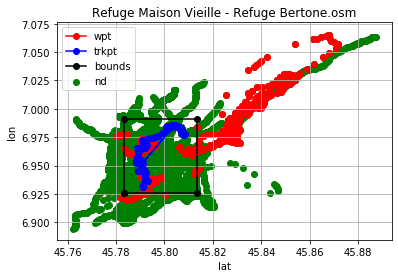

In [10]:
analyzer('./GPX_Tracks/4sDDFdd4cjA.gpx', 29)

In [11]:
def around(loc, osm_nds, radius = 0.005):
    
    lat, lon = float(loc[0]), float(loc[1])
    # naive surrounding, adjusted by radius
    minlat, maxlat = (lat - radius), (lat + radius)
    minlon, maxlon = (lon - radius), (lon + radius)
    
    surround = []
    for nd in osm_nds:
        nd_lat, nd_lon = float(osm_nds[nd]['loc'][0]), float(osm_nds[nd]['loc'][1])
        if (nd_lat >= minlat and nd_lat <= maxlat) and (nd_lon >= minlon and nd_lon <= maxlon):
            # we only care about the surrounded nodes that is interested
            if osm_nds[nd]['isinterested'] == 'yes':
                surround.append(nd)
    
    return surround

In [12]:
def gen_rdf(gpx_file):
    
    trk_name, trk_wpts, trk_trkpts = gpx_parser(gpx_file)  
    osm_file = link2osm(gpx_file)
    osm_bounds, osm_nds, osm_ways, osm_rlts = osm_parser(osm_file)
    
    trk_surround = [] # hassurround
    trkpt_surround = [] # hassurround
    for trkpt in trk_trkpts:
        trkpt_loc = trk_trkpts[trkpt]['loc']
     
        trkpt_surround = around(trkpt_loc, osm_nds)
        trk_trkpts[trkpt]['surround'] = trkpt_surround
        
        trk_surround += trkpt_surround
        
    trk_surround = list(set(trk_surround))
    
    trk_surround_ways = []
    for nd in trk_surround:
        for way in osm_nds[nd]['ways']:
            trk_surround_ways.append(way)
            
    trk_surround_ways = list(set(trk_surround_ways))
    
    with open('%s.ttl'%(trk_name), 'w') as f:
        f.write('@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .\n')
        f.write('@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .\n')
        f.write('@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .\n')
        f.write('\n')
        f.write('@prefix : <http://www.topografix.com/GPX/1/1>. \n')
        f.write('\n')
        
        f.write(':%s a :GPXtrack .\n'%(trk_name))
        f.write('\n')
        
        ltrk_wpts = ':%s :haswpt '%(trk_name)
        for wpt in trk_wpts:
            ltrk_wpts += ':%s, '%(wpt)
        ltrk_wpts = ltrk_wpts[:-2] + ' .\n'
        f.write(ltrk_wpts)
        f.write('\n')
        
        ltrk_trkpts = ':%s :hastrkpt '%(trk_name)
        for trkpt in trk_trkpts:
            ltrk_trkpts += ':%s, '%(trkpt)
        ltrk_trkpts = ltrk_trkpts[:-2] + ' .\n'
        f.write(ltrk_trkpts)
        f.write('\n')
        
        ltrk_surround = ':%s :hassurround '%(trk_name)
        for nd in trk_surround:
            ltrk_surround += ':%s, '%(nd)
        ltrk_surround = ltrk_surround[:-2] + ' .\n'
        f.write(ltrk_surround)
        f.write('\n')
        
        for wpt in trk_wpts:
            f.write(':%s :hasloc :(%s, %s) ;\n'%(wpt, trk_wpts[wpt]['loc'][0], trk_wpts[wpt]['loc'][1]))
            f.write(' ' * (len(wpt) + 2) + ':hasele :%s ;\n'%(trk_wpts[wpt]['ele']))
            f.write(' ' * (len(wpt) + 2) + ':hastime :%s ;\n'%(trk_wpts[wpt]['time']))
            f.write(' ' * (len(wpt) + 2) + ':hasname :%s .\n'%(trk_wpts[wpt]['name']))
            f.write('\n')
        
        for trkpt in trk_trkpts:
            f.write(':%s :hasloc :(%s, %s) ;\n'%(trkpt, trk_trkpts[trkpt]['loc'][0], trk_trkpts[trkpt]['loc'][1]))
            f.write(' ' * (len(trkpt) + 2) + ':hasele :%s ;\n'%(trk_trkpts[trkpt]['ele']))
            f.write(' ' * (len(trkpt) + 2) + ':hastime :%s ;\n'%(trk_trkpts[trkpt]['time']))
            ltrk_trkpts_surround = ' ' * (len(trkpt) + 2) + ':hassurround '
            for nd in trk_trkpts[trkpt]['surround']:
                ltrk_trkpts_surround += ':%s, '%(nd)
            ltrk_trkpts_surround = ltrk_trkpts_surround[:-2] + ' .\n'
            f.write(ltrk_trkpts_surround)
            f.write('\n')
                 
        for nd in trk_surround:
            f.write(':%s :hasloc :(%s, %s) ;\n'%(nd, osm_nds[nd]['loc'][0], osm_nds[nd]['loc'][1]))
            f.write(' ' * (len(nd) + 2) + ':hasid :%s ;\n'%(osm_nds[nd]['id']))
            f.write(' ' * (len(nd) + 2) + ':hasts :%s ;\n'%(osm_nds[nd]['ts']))
            f.write(' ' * (len(nd) + 2) + ':hasname :%s ;\n'%(osm_nds[nd]['name']))
            f.write(' ' * (len(nd) + 2) + ':isinterested :%s ;\n'%(osm_nds[nd]['isinterested']))
            ltrk_surround_way = ' ' * (len(nd) + 2) + ':ontheway '
            for way in osm_nds[nd]['ways']:
                ltrk_surround_way += ':%s, '%(way)
            ltrk_surround_way = ltrk_surround_way[:-2] + ' ;\n'
            f.write(ltrk_surround_way)
            ltrk_surround_rlt = ' ' * (len(nd) + 2) + ':intherlt '
            for rlt in osm_nds[nd]['rlts']:
                ltrk_surround_rlt += ':%s, '%(rlt)
            ltrk_surround_rlt = ltrk_surround_rlt[:-2] + ' .\n'
            f.write(ltrk_surround_rlt)
            f.write('\n')
            
        for way in trk_surround_ways:
            f.write(':%s :hasid :%s ;\n'%(way, osm_ways[way]['id']))
            f.write(' ' * (len(way) + 2) + ':hasname :%s ;\n'%(osm_ways[way]['name']))
            f.write(' ' * (len(way) + 2) + ':isinterested :%s ;\n'%(osm_ways[way]['isinterested']))
            ltrk_surround_way_nd = ' ' * (len(way) + 2) + ':hasnd '
            for nd in osm_ways[way]['nds']:
                ltrk_surround_way_nd += ':%s, '%(nd)
            ltrk_surround_way_nd = ltrk_surround_way_nd[:-2] + ' ;\n'
            f.write(ltrk_surround_way_nd)
            ltrk_surround_way_rlt = ' ' * (len(way) + 2) + ':intherlt '
            for rlt in osm_ways[way]['rlts']:
                ltrk_surround_way_rlt += ':%s, '%(rlt)
            ltrk_surround_way_rlt = ltrk_surround_way_rlt[:-2] + ' .\n'
            f.write(ltrk_surround_way_rlt)
            f.write('\n')
    
        
    
    

osm bounds:  (45.783124, 6.926023, 45.813638000000005, 6.990976)
Refuge Maison Vieille - Refuge Bertone.osm downloaded


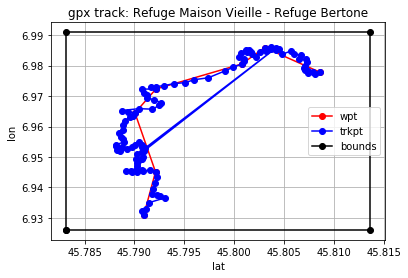

In [13]:
gen_rdf('./GPX_Tracks/4sDDFdd4cjA.gpx')